# Factor Allocation Strategy

**Point-in-Time FRED-MD** macroeconomic data to predict factor allocation.

**Model**: MICRO Transformer (12k params)

## Rigorous Evaluation Methodology

```
┌─────────────────────────────────────────────────────────────────┐
│ STEP 1: WALK-FORWARD (2017-2021)                                │
│   - Train N models on expanding windows                         │
│   - Test each on 1 year OOS (non-overlapping)                   │
│   - HOLDOUT: 2022-2024 reserved (no model sees these)           │
│   - Save all N models for WF ensemble                           │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ STEP 2: FINAL MODEL                                             │
│   - Train on 2000-2021 (all data except holdout)                │
│   - Single model (seed=999) for production use                  │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ STEP 3: HOLDOUT EVALUATION (2022-2024)                          │
│   - Train FAIR ENSEMBLE (5 models, same data, diff seeds)       │
│   - Evaluate: Final vs Fair Ensemble vs WF Ensemble             │
│   - Fair comparison: Final vs Fair Ensemble (same data)         │
│   - Data bias: Fair Ensemble vs WF Ensemble (different data)    │
└─────────────────────────────────────────────────────────────────┘
```

### Why Fair Ensemble?

| Comparison | What it measures |
|------------|------------------|
| Final vs Fair Ensemble | Pure ensemble effect (same data, different seeds) |
| Fair vs WF Ensemble | Data quantity bias (different training periods) |

## 16 Combinations

| Strategy | Allocation | Horizons |
|----------|------------|-----------|
| E2E (3-phase) | Binary (2F) | 1M, 3M, 6M, 12M |
| E2E (3-phase) | Multi (6F) | 1M, 3M, 6M, 12M |
| Supervised | Binary (2F) | 1M, 3M, 6M, 12M |
| Supervised | Multi (6F) | 1M, 3M, 6M, 12M |

**Key**: All models rebalance monthly. Horizon = Sharpe optimization target.

In [1]:
# ============================================================
# IMPORTS & RELOAD (Run this cell to reload all modules)
# ============================================================
# This cell imports all modules used in this notebook and provides
# a reload_all() function to refresh them after code changes.

%matplotlib inline

import sys
import warnings
import importlib
from pathlib import Path

warnings.filterwarnings('ignore')

# Setup project path
project_root = Path.cwd().parent
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

# ============================================================
# Standard library imports
# ============================================================
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ============================================================
# Project module imports (with reload support)
# ============================================================

# Data loaders
import data.point_in_time_loader
import data.factor_data_loader
import data.data_loader

from data.point_in_time_loader import PointInTimeFREDMDLoader, PointInTimeConfig
from data.factor_data_loader import FactorDataLoader, FactorDataConfig
from data.data_loader import Region

# Feature engineering
import features.feature_engineering
import features.feature_selection

from features.feature_engineering import FeatureEngineer, FeatureConfig
from features.feature_selection import (
    IndicatorSelector,
    PCAFeatureReducer,
    SelectionConfig,
    PCAConfig,
)

# Comparison runner
import comparison_runner
from comparison_runner import (
    prepare_data,
    run_combination_walk_forward,
    train_final_model,
    train_fair_ensemble_models,
    evaluate_on_holdout,
    ensemble_predict,
    compute_composite_score,
)

# Pipelines
import pipelines
import pipelines.three_step_pipeline
from pipelines import ThreeStepEvaluation
from pipelines.three_step_pipeline import EvaluationConfig

# Visualization
import visualization
import visualization.walk_forward_plots
import visualization.holdout_plots
import visualization.colormaps

from visualization import plot_all_walk_forward, plot_all_holdout

# Utilities
import utils.metrics
import utils.benchmarks
import utils.walk_forward

from utils.benchmarks import compute_all_benchmarks
from utils.metrics import compute_total_return, compute_max_drawdown

# ============================================================
# RELOAD FUNCTION
# ============================================================

def reload_all():
    """
    Reload all project modules.
    
    Call this function after modifying source code to pick up changes
    without restarting the kernel.
    
    Usage:
        reload_all()
    """
    modules_to_reload = [
        # Data (order matters: base modules first)
        data.data_loader,
        data.point_in_time_loader,
        data.factor_data_loader,
        # Features
        features.feature_engineering,
        features.feature_selection,
        # Utils
        utils.metrics,
        utils.walk_forward,
        utils.benchmarks,
        # Core
        comparison_runner,
        # Visualization
        visualization.colormaps,
        visualization.walk_forward_plots,
        visualization.holdout_plots,
        visualization,
        # Pipelines
        pipelines.three_step_pipeline,
        pipelines,
    ]
    
    for module in modules_to_reload:
        try:
            importlib.reload(module)
        except Exception as e:
            print(f"Warning: Could not reload {module.__name__}: {e}")
    
    # Re-import key functions after reload
    global PointInTimeFREDMDLoader, PointInTimeConfig
    global FactorDataLoader, FactorDataConfig, Region
    global FeatureEngineer, FeatureConfig
    global IndicatorSelector, PCAFeatureReducer, SelectionConfig, PCAConfig
    global prepare_data, compute_composite_score
    global ThreeStepEvaluation, EvaluationConfig
    global plot_all_walk_forward, plot_all_holdout
    global compute_all_benchmarks
    
    from data.point_in_time_loader import PointInTimeFREDMDLoader, PointInTimeConfig
    from data.factor_data_loader import FactorDataLoader, FactorDataConfig
    from data.data_loader import Region
    from features.feature_engineering import FeatureEngineer, FeatureConfig
    from features.feature_selection import IndicatorSelector, PCAFeatureReducer, SelectionConfig, PCAConfig
    from comparison_runner import prepare_data, compute_composite_score
    from pipelines import ThreeStepEvaluation
    from pipelines.three_step_pipeline import EvaluationConfig
    from visualization import plot_all_walk_forward, plot_all_holdout
    from utils.benchmarks import compute_all_benchmarks
    
    print("All modules reloaded successfully!")

# ============================================================
# Set random seeds for reproducibility
# ============================================================
np.random.seed(42)
torch.manual_seed(42)

print("Imports complete. Use reload_all() to refresh modules after code changes.")

Imports complete. Use reload_all() to refresh modules after code changes.


In [2]:
# ============================================================
# SETUP (simplified - imports are in the cell above)
# ============================================================

# This cell is kept for compatibility but imports are now centralized above.
# Just verify setup is complete.

print(f"Project root: {project_root}")
print(f"NumPy: {np.__version__}, Pandas: {pd.__version__}, PyTorch: {torch.__version__}")
print("Setup complete")

Project root: /Users/mathis/Finance-Quant-thinking/Strategies/factor_allocation_strategy_macro
NumPy: 2.4.1, Pandas: 2.3.3, PyTorch: 2.10.0
Setup complete


In [3]:
# ============================================================
# DATA LOADING
# ============================================================

# Load Point-in-Time FRED-MD
vintages_dir = project_root / "data_cache" / "vintages"

pit_loader = PointInTimeFREDMDLoader(
    PointInTimeConfig(
        vintages_dir=vintages_dir,
        publication_lag=1,
        apply_transformations=True
    )
)

macro_data = pit_loader.create_pit_macro_dataframe(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

market_data = pit_loader.create_pit_market_context(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

indicators = pit_loader.get_indicators()

# Load factor returns
factor_loader = FactorDataLoader(
    FactorDataConfig(
        start_date="2000-01-01",
        end_date="2024-12-31",
        cache_dir=project_root / "data_cache" / "factors",
        use_cache=True
    )
)

factor_data = factor_loader.load_all_factors()

print(f"\nData loaded: {len(macro_data)} macro obs, {len(factor_data)} factor obs")

Indexed 305 vintage files
  Coverage: 1999-08 to 2024-12
Loading cached all factors from /Users/mathis/Finance-Quant-thinking/Strategies/factor_allocation_strategy_macro/data_cache/factors/all_factors.parquet

Data loaded: 32799 macro obs, 288 factor obs


---
## Model Configuration

In [4]:
# ============================================================
# CONFIGURATION
# ============================================================

# MICRO Transformer (12k params - reduced to prevent overfitting)
CONFIG = {
    # Architecture
    "sequence_length": 12,
    "num_factors": 6,
    "d_model": 32,
    "num_heads": 1,
    "num_layers": 1,
    "d_ff": 64,
    "dropout": 0.6,
    
    # Training
    "learning_rate": 0.001,
    "batch_size": 32,
    "weight_decay": 0.02,
    "epochs_phase1": 20,
    "epochs_phase2": 15,
    "epochs_phase3": 15,
    
    # Backtest
    "execution_threshold": 0.05,
    "transaction_cost": 0.001,
    "val_split": 0.2,
}

# Feature engineering
feature_config = FeatureConfig(
    sequence_length=12,
    include_momentum=True,
    include_market_context=True,
    use_fred_md=True,
    aggregation_windows=[1, 3, 6, 12]
)

feature_engineer = FeatureEngineer(
    config=feature_config,
    region=Region.US,
    fred_md_indicators=indicators
)

print(f"Model: d_model={CONFIG['d_model']}, layers={CONFIG['num_layers']}, heads={CONFIG['num_heads']}")
print(f"Features: {feature_engineer.get_num_indicators()} indicators")

Model: d_model=32, layers=1, heads=1
Features: 112 indicators


---
## Feature Selection & PCA (Optional)

Reduce dimensionality from 112 indicators to improve generalization.

In [5]:
# ============================================================
# FEATURE SELECTION & PCA DEMO
# ============================================================

# Create target data for 1M horizon
target_1m = factor_loader.create_binary_target(factor_data, horizon_months=1)

# --- OPTION 1: Indicator Selection (Mutual Information) ---
print("=" * 60)
print("INDICATOR SELECTION (Mutual Information)")
print("=" * 60)

selector = feature_engineer.create_indicator_selector(
    macro_data=macro_data,
    target_data=target_1m,
    method="mutual_info",
    n_features=30,  # Keep top 30 indicators
)

# Show top indicators
rankings = selector.get_indicator_rankings()
print(f"\nTop 10 indicators (out of {len(rankings)}):")
print(rankings.head(10).to_string(index=False))

# Apply selection
macro_filtered = feature_engineer.apply_indicator_selection(macro_data, selector)
print(f"\nFiltered: {len(macro_data)} -> {len(macro_filtered)} observations")
print(f"Unique indicators: {macro_data['indicator'].nunique()} -> {macro_filtered['indicator'].nunique()}")

# --- OPTION 2: PCA on Flat Features ---
print("\n" + "=" * 60)
print("PCA DIMENSIONALITY REDUCTION")
print("=" * 60)

pca_reducer = feature_engineer.create_pca_reducer(
    macro_data=macro_data,
    factor_data=factor_data,
    market_data=market_data,
    target_data=target_1m,
    n_components=20,  # Keep 20 components
)

variance_ratio, total_var = pca_reducer.get_explained_variance()
print(f"\nPCA: {len(variance_ratio)} components -> {total_var:.1%} variance explained")
print(f"Top 5 components: {variance_ratio[:5].round(3)}")

# Example: Get PCA-reduced features for one date
sample_date = target_1m.iloc[100]["timestamp"]
pca_features = feature_engineer.create_flat_features_with_pca(
    macro_data, factor_data, market_data, sample_date, pca_reducer
)
print(f"\nExample: date={sample_date.date()}")
print(f"  Original features: ~100 -> PCA features: {len(pca_features)}")


Created binary targets: 287 observations
Target distribution:
target
1    149
0    138
Name: count, dtype: int64
INDICATOR SELECTION (Mutual Information)

Top 10 indicators (out of 112):
    indicator    score  selected  rank
       HOUSTW 0.051255      True     1
CES0600000008 0.044960      True     2
       T1YFFM 0.044825      True     3
       INVEST 0.043641      True     4
       USGOOD 0.041941      True     5
        CP3Mx 0.040196      True     6
     TOTRESNS 0.039409      True     7
      T10YFFM 0.038820      True     8
  CUSR0000SAS 0.034391      True     9
  CUSR0000SAD 0.033069      True    10

Filtered: 32799 -> 8645 observations
Unique indicators: 112 -> 30

PCA DIMENSIONALITY REDUCTION

PCA: 20 components -> 87.8% variance explained
Top 5 components: [0.118 0.11  0.08  0.066 0.065]

Example: date=2008-05-01
  Original features: ~100 -> PCA features: 20


---
## Walk-Forward Hyperparameter Tuning (Optional)

Tune hyperparameters **before training** using walk-forward validation:
- Respects temporal order (no look-ahead bias)
- Uses Bayesian optimization (Optuna) or random search
- Optimizes validation Sharpe ratio

If enabled, tuned parameters will be used for the 16-combination training below.

In [6]:
# ============================================================
# WALK-FORWARD HYPERPARAMETER TUNING (OPTIONAL)
# ============================================================
# Set RUN_TUNING = True to enable (takes ~10-15 min with 15 trials)

RUN_TUNING = False  # Default: OFF (set True to enable HP tuning)
USE_FEATURE_SELECTION = False  # Default: OFF (set True to reduce features)
N_TRIALS = 15  # Number of trials per window (if tuning enabled)

# Prepare target data for tuning
targets, cumulative_returns = prepare_data(factor_loader, factor_data)

if RUN_TUNING:
    from comparison_runner import run_with_tuning
    
    # Tune on 3M horizon (best performing)
    target_3m = targets[3]
    
    print("Running walk-forward HP tuning...")
    print("This will find optimal hyperparameters for each temporal window.\n")
    
    tuning_summary, tuning_results = run_with_tuning(
        macro_data=macro_data,
        factor_data=factor_data,
        market_data=market_data,
        target_data=target_3m,
        indicators=indicators,
        feature_engineer=feature_engineer,
        config=CONFIG,
        strategy="supervised",
        n_trials=N_TRIALS,
        optimization_metric="sharpe",
        verbose=True,
    )
    
    # Update CONFIG with tuned parameters
    TUNED_CONFIG = CONFIG.copy()
    best_params = tuning_summary.get("best_params", {})
    for key, value in best_params.items():
        if key in TUNED_CONFIG:
            TUNED_CONFIG[key] = value
    
    print("\n" + "=" * 60)
    print("TUNED CONFIGURATION (will be used for training)")
    print("=" * 60)
    for k in ["learning_rate", "dropout", "weight_decay", "batch_size",
              "epochs_phase1", "epochs_phase2", "epochs_phase3"]:
        old_val = CONFIG.get(k)
        new_val = TUNED_CONFIG.get(k)
        changed = " <- TUNED" if old_val != new_val else ""
        print(f"  {k}: {new_val}{changed}")
else:
    TUNED_CONFIG = CONFIG.copy()
    print("Walk-forward tuning disabled. Using default CONFIG.")
    print("Set RUN_TUNING = True to enable hyperparameter tuning.")


Horizon 1M: 287 observations
  Target distribution: {1: np.int64(149), 0: np.int64(138)}

Horizon 3M: 285 observations
  Target distribution: {1: np.int64(154), 0: np.int64(131)}

Horizon 6M: 282 observations
  Target distribution: {1: np.int64(144), 0: np.int64(138)}

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
Walk-forward tuning disabled. Using default CONFIG.
Set RUN_TUNING = True to enable hyperparameter tuning.


---
## STEP 1: Walk-Forward Validation (with Holdout)

**Proper OOS evaluation with 2-year holdout:**
- Train N models on expanding windows (2000-2013 -> 2000-2020)
- Test each on 1 year OOS (2017, 2018, ..., 2022)
- **HOLDOUT 2023-2024**: No model sees these years during training
- Save all N models for ensemble comparison

This gives us TRUE out-of-sample metrics for 2017-2022.

In [7]:
# ============================================================
# STEP 1: WALK-FORWARD WITH HOLDOUT
# ============================================================

# Configuration for evaluation
eval_config = EvaluationConfig(
    holdout_years=3,
    holdout_start_date="2022-01-01",
    horizons=[1, 3, 6, 12],
    save_models=True,
    verbose=True,
    # Fair Ensemble configuration (eliminates data quantity bias)
    train_fair_ensemble=True,  # Train 5 models on same data with different seeds
    fair_ensemble_n_models=5,
    fair_ensemble_base_seed=42,
    fair_ensemble_seed_step=100,
    # Bias analysis (optional - set True to decompose effects)
    run_bias_analysis=False,
    bias_cutoff_years=[2014, 2017, 2020],
)

# Create evaluator
evaluator = ThreeStepEvaluation(
    macro_data=macro_data,
    factor_data=factor_data,
    market_data=market_data,
    indicators=indicators,
    feature_engineer=feature_engineer,
    model_config=TUNED_CONFIG,
    factor_loader=factor_loader,
    eval_config=eval_config,
)

# Run Step 1: Walk-forward validation
evaluator.run_step1_walk_forward()
all_wf_results = evaluator.wf_results

# Print walk-forward summary
wf_summary = evaluator._build_walk_forward_summary()
print("\n" + "=" * 80)
print("WALK-FORWARD SUMMARY (2017-2021)")
print("=" * 80)
print(f"\n{'Strategy':<8} {'Alloc':<7} {'H':<4} {'OOS Sharpe':>11} {'IC':>8} {'MaxDD':>9} {'Score':>8} {'Rank':>6}")
print("-" * 75)
for _, row in wf_summary.iterrows():
    print(f"{row['strategy']:<8} {row['allocation']:<7} {row['horizon']}M{'':<2} "
          f"{row['true_oos_sharpe']:>+11.4f} {row['avg_ic']:>+8.4f} "
          f"{row['true_oos_maxdd']:>+9.4f} {row['score']:>8.4f} {int(row['rank']):>6}")

best = wf_summary.iloc[0]
print("-" * 75)
print(f"\nBEST: {best['strategy']} + {best['allocation']} @ {best['horizon']}M "
      f"-> Score={best['score']:.4f}")


Horizon 1M: 287 observations
  Target distribution: {1: np.int64(149), 0: np.int64(138)}

Horizon 3M: 285 observations
  Target distribution: {1: np.int64(154), 0: np.int64(131)}

Horizon 6M: 282 observations
  Target distribution: {1: np.int64(144), 0: np.int64(138)}

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
STEP 1: WALK-FORWARD VALIDATION
Holdout: 2022-01-01 onwards (FIXED for all horizons)
Running 16 combinations...


[1/16] E2E + Binary @ 1M
  Avg Sharpe: +1.8252, Avg IC: -0.0744, Models saved: 5

[2/16] E2E + Binary @ 3M
  Avg Sharpe: +1.7608, Avg IC: -0.2020, Models saved: 5

[3/16] E2E + Binary @ 6M
  Avg Sharpe: +1.6743, Avg IC: +0.1718, Models saved: 5

[4/16] E2E + Binary @ 12M
  Avg Sharpe: +1.6846, Avg IC: +0.1442, Models saved: 5

[5/16] E2E + Multi @ 1M
  Avg Sharpe: +1.9693, Avg IC: +0.1089, Models saved: 5

[6/16] E2E + Multi @ 3M
  Avg Sharpe: +1.8197, Avg IC: +0.2306, Models saved: 5

[7/16] E2E + Multi @ 6M
  Avg Shar

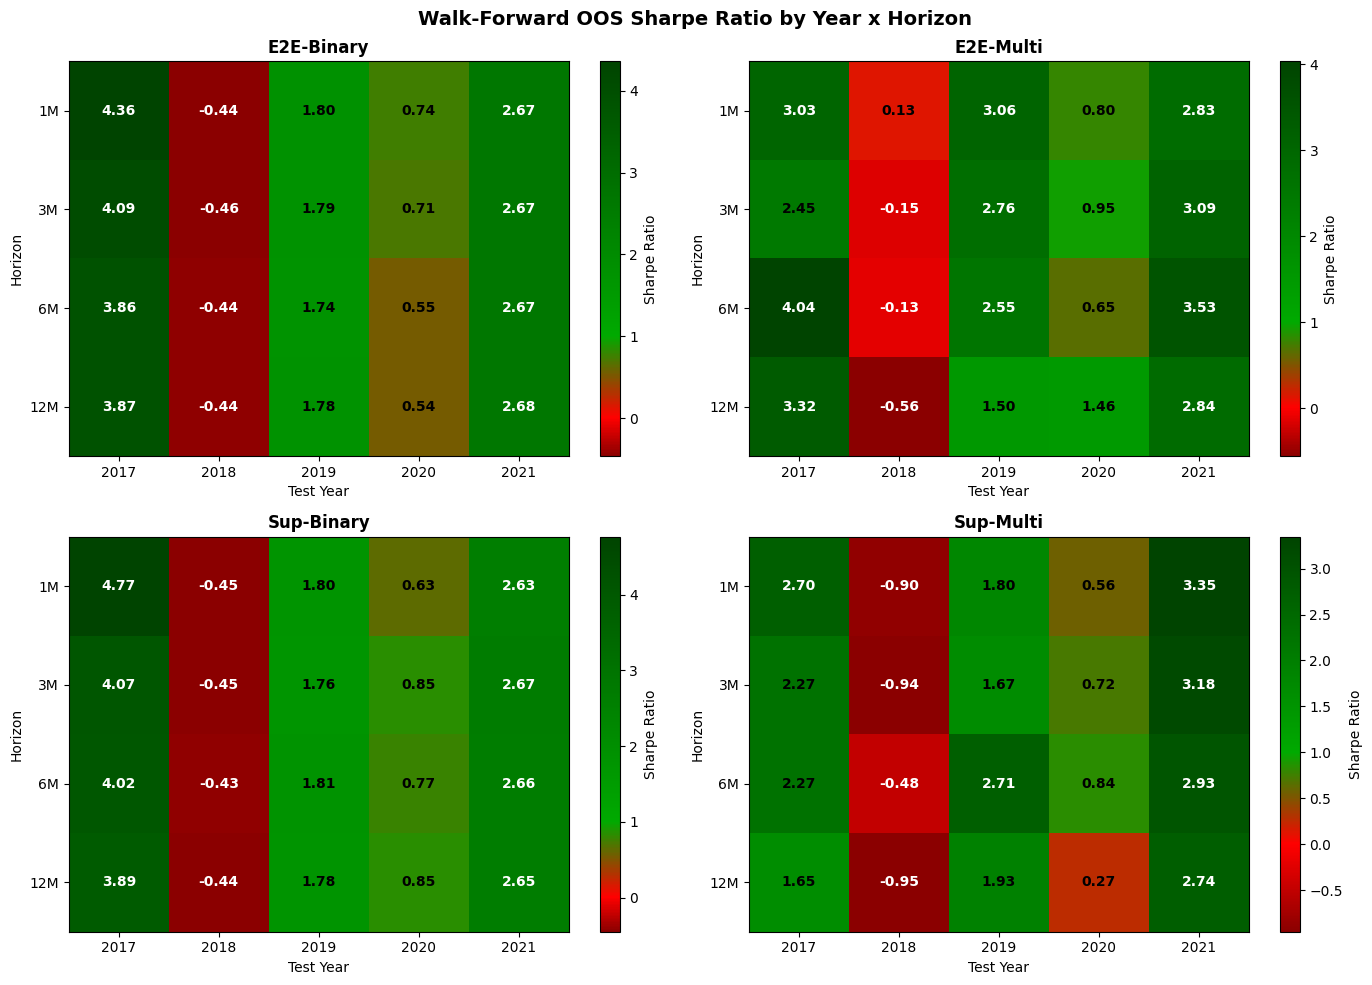

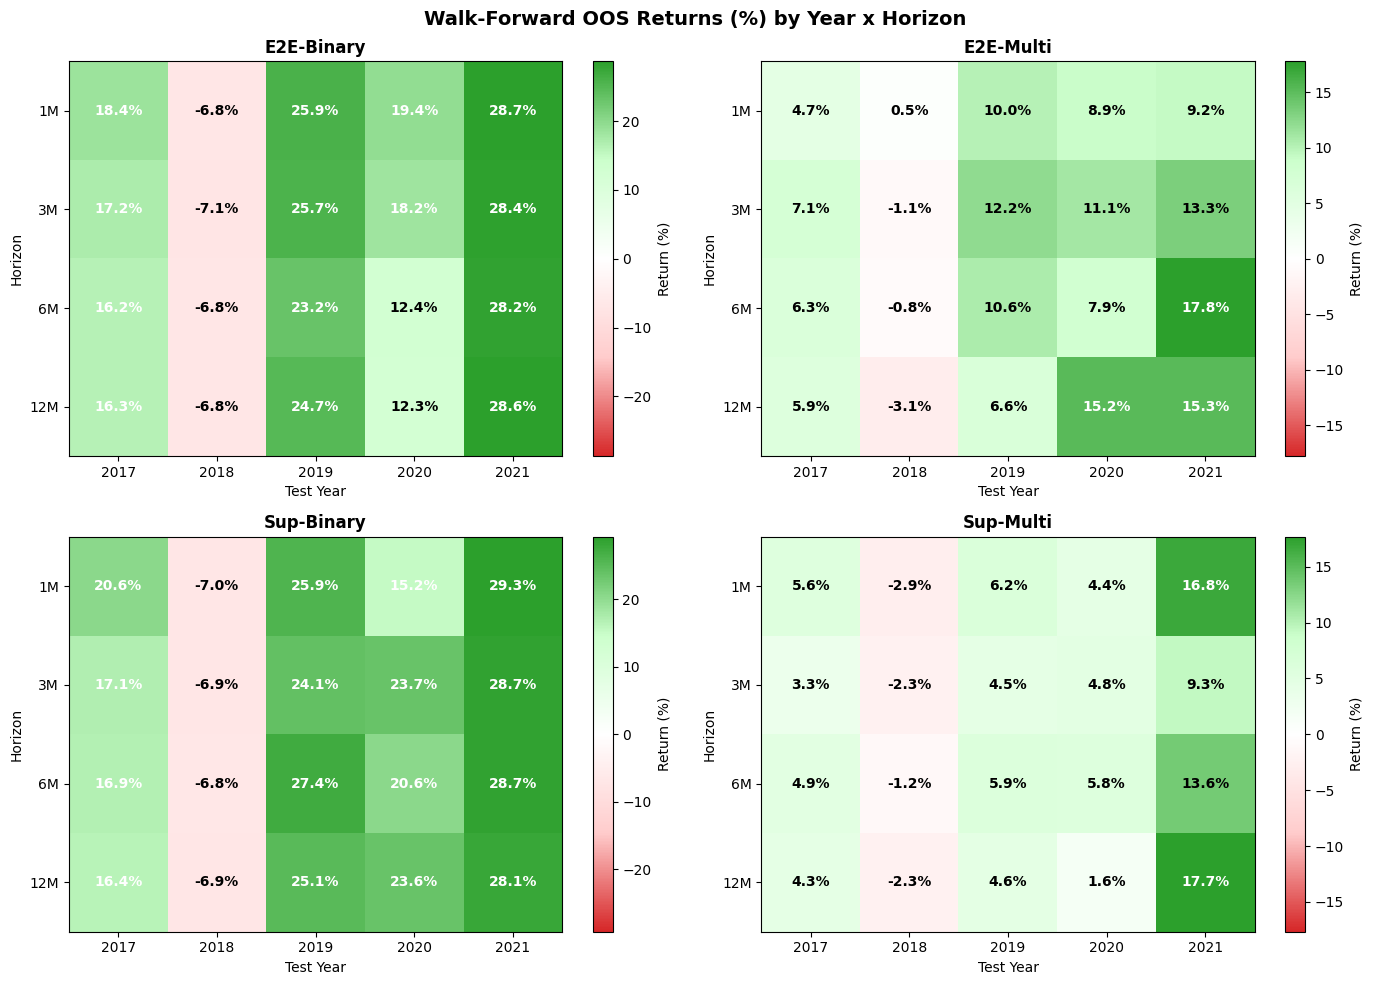

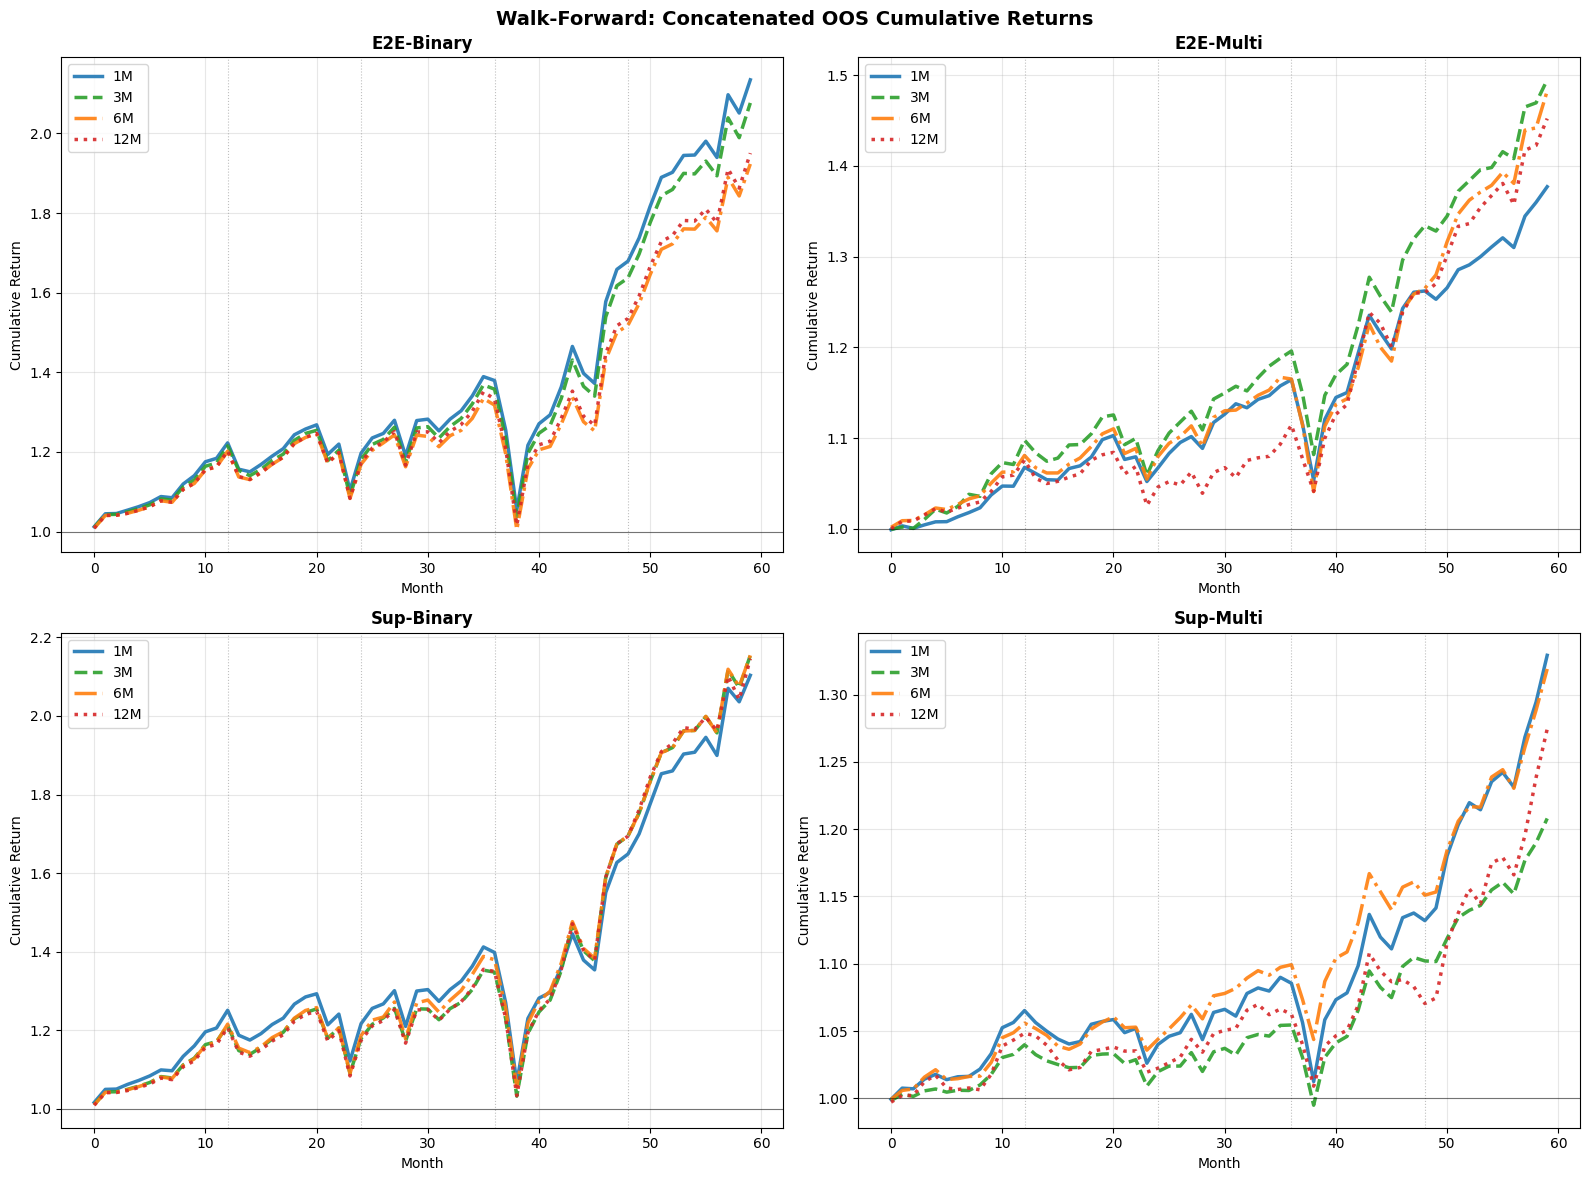

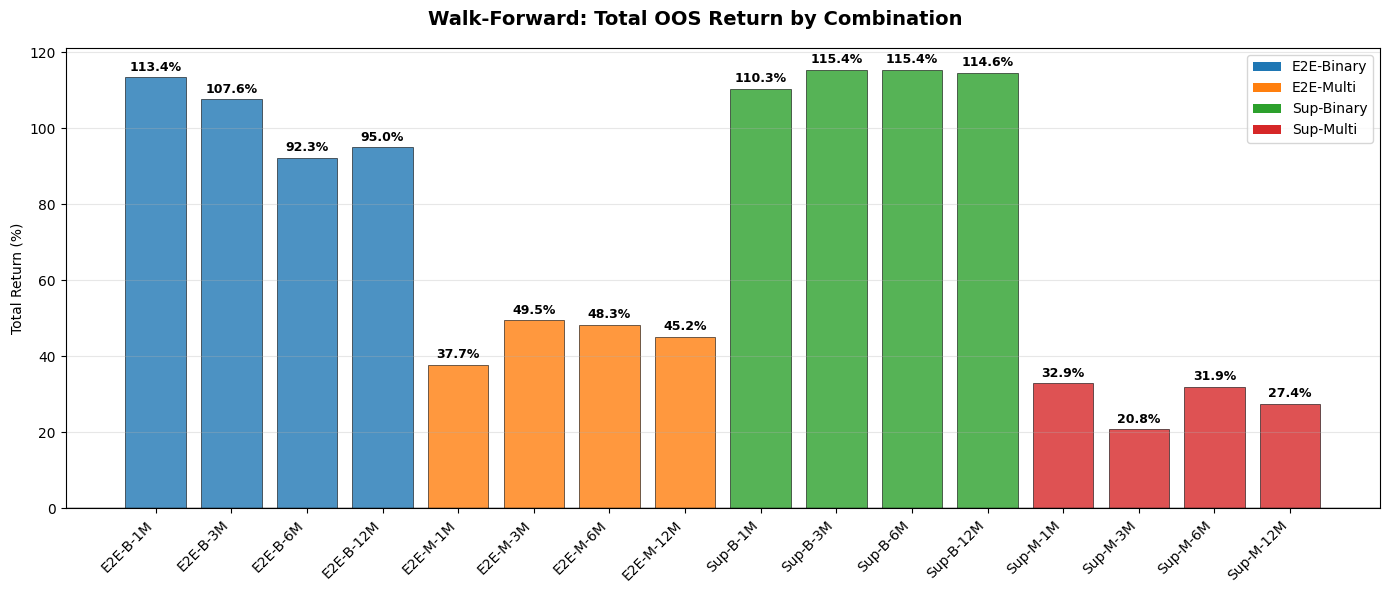

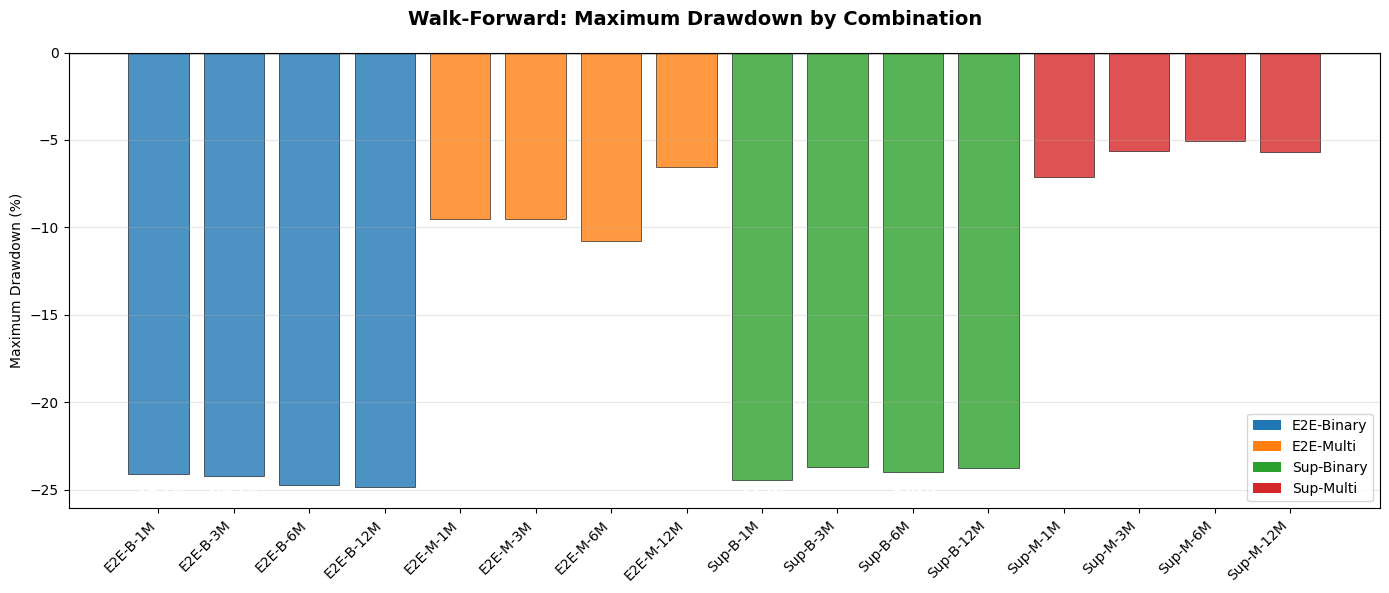


WALK-FORWARD SUMMARY BY YEAR

Combination             2017      2018      2019      2020      2021       TOTAL      MAX DD
--------------------------------------------------------------------------------------------
E2E-B-1M               +18.4%      -6.8%     +25.9%     +19.4%     +28.7%      +113.4%       -24.1%
E2E-B-3M               +17.2%      -7.1%     +25.7%     +18.2%     +28.4%      +107.6%       -24.2%
E2E-B-6M               +16.2%      -6.8%     +23.2%     +12.4%     +28.2%       +92.3%       -24.7%
E2E-B-12M              +16.3%      -6.8%     +24.7%     +12.3%     +28.6%       +95.0%       -24.8%
E2E-M-1M                +4.7%      +0.5%     +10.0%      +8.9%      +9.2%       +37.7%        -9.5%
E2E-M-3M                +7.1%      -1.1%     +12.2%     +11.1%     +13.3%       +49.5%        -9.5%
E2E-M-6M                +6.3%      -0.8%     +10.6%      +7.9%     +17.8%       +48.3%       -10.8%
E2E-M-12M               +5.9%      -3.1%      +6.6%     +15.2%     +15.3%       +45

[<Figure size 1400x1000 with 8 Axes>,
 <Figure size 1400x1000 with 8 Axes>,
 <Figure size 1600x1200 with 4 Axes>,
 <Figure size 1400x600 with 1 Axes>,
 <Figure size 1400x600 with 1 Axes>]

In [8]:
# ============================================================
# WALK-FORWARD VISUALIZATIONS
# ============================================================

plot_all_walk_forward(all_wf_results)

---
## STEP 2: Train Final Models (All 16 Combinations)

Train a single model on **all data except holdout** for each combination.

The holdout period is determined by the actual data range (last N years of available targets).

In [9]:
# ============================================================
# STEP 2: TRAIN FINAL MODELS
# ============================================================

evaluator.run_step2_final_models()
all_final_models = evaluator.final_models

print(f"\n{'=' * 80}")
print(f"STEP 2 COMPLETE: {sum(1 for v in all_final_models.values() if v is not None)}/16 models trained")
print("=" * 80)


STEP 2: TRAINING FINAL MODELS
Training period: 2000-01-01 to 2022-12-31
Training all 16 combinations...

[1/16] Training E2E + Binary @ 1M
  -> Model trained successfully
[2/16] Training E2E + Binary @ 3M
  -> Model trained successfully
[3/16] Training E2E + Binary @ 6M
  -> Model trained successfully
[4/16] Training E2E + Binary @ 12M
  -> Model trained successfully
[5/16] Training E2E + Multi @ 1M
  -> Model trained successfully
[6/16] Training E2E + Multi @ 3M
  -> Model trained successfully
[7/16] Training E2E + Multi @ 6M
  -> Model trained successfully
[8/16] Training E2E + Multi @ 12M
  -> Model trained successfully
[9/16] Training Sup + Binary @ 1M
  -> Model trained successfully
[10/16] Training Sup + Binary @ 3M
  -> Model trained successfully
[11/16] Training Sup + Binary @ 6M
  -> Model trained successfully
[12/16] Training Sup + Binary @ 12M
  -> Model trained successfully
[13/16] Training Sup + Multi @ 1M
  -> Model trained successfully
[14/16] Training Sup + Multi @ 3M


---
## STEP 3: Holdout Evaluation (All 16 Combinations)

Compare **Final Model** vs **Fair Ensemble** vs **WF Ensemble** on the holdout period:

| Model Type | Description | Data Used |
|------------|-------------|-----------|
| **Final** | Single model (seed=999) | 2000-2021 (full) |
| **Fair Ensemble** | 5 models averaged (seeds 42,142,...) | 2000-2021 (full) |
| **WF Ensemble** | N walk-forward models averaged | 2000-2014 to 2000-2020 (less data) |

**Why Fair Ensemble?**
- WF Ensemble has a **data quantity bias**: each model sees different amounts of data
- Fair Ensemble uses **same data, different seeds**: isolates pure ensemble effect
- Comparison: Final vs Fair Ensemble = pure ensemble effect (no data confound)

In [10]:
# ============================================================
# STEP 3: HOLDOUT EVALUATION (with Fair Ensemble)
# ============================================================

evaluator.run_step3_holdout()
all_holdout_results = evaluator.holdout_results

# Print holdout summary
holdout_summary = evaluator._build_holdout_summary()
print("\n" + "=" * 120)
print("HOLDOUT RESULTS SUMMARY (Final vs Fair Ensemble vs WF Ensemble)")
print("=" * 120)
print(f"\n{'Strategy':<8} {'Alloc':<7} {'H':<4} {'Type':<14} {'Sharpe':>10} {'IC':>10} {'MaxDD':>10} {'Score':>8} {'Rank':>6}")
print("-" * 95)

for _, row in holdout_summary.iterrows():
    print(f"{row['strategy']:<8} {row['allocation']:<7} {row['horizon']}M{'':<2} "
          f"{row['model_type']:<14} {row['sharpe']:>+10.4f} {row['ic']:>+10.4f} "
          f"{row['maxdd']:>+10.4f} {row['score']:>8.4f} {int(row['rank']):>6}")

print("=" * 120)

# Winner summary (Final vs Fair Ensemble)
final_df = holdout_summary[holdout_summary['model_type'] == 'Final']
fair_df = holdout_summary[holdout_summary['model_type'] == 'Fair Ensemble']
wf_df = holdout_summary[holdout_summary['model_type'] == 'WF Ensemble']

if len(fair_df) > 0:
    # Compare Final vs Fair Ensemble (fair comparison)
    final_wins = 0
    fair_wins = 0
    for _, final_row in final_df.iterrows():
        key = (final_row['strategy'], final_row['allocation'], final_row['horizon'])
        fair_match = fair_df[(fair_df['strategy'] == key[0]) & 
                              (fair_df['allocation'] == key[1]) & 
                              (fair_df['horizon'] == key[2])]
        if len(fair_match) > 0:
            if final_row['sharpe'] > fair_match.iloc[0]['sharpe']:
                final_wins += 1
            else:
                fair_wins += 1
    
    print(f"\nFINAL vs FAIR ENSEMBLE (fair comparison): {final_wins} Final wins, {fair_wins} Fair Ensemble wins")
    
    # Compare Fair Ensemble vs WF Ensemble (shows data quantity bias)
    if len(wf_df) > 0:
        fair_better = 0
        wf_better = 0
        total_delta = 0
        for _, fair_row in fair_df.iterrows():
            key = (fair_row['strategy'], fair_row['allocation'], fair_row['horizon'])
            wf_match = wf_df[(wf_df['strategy'] == key[0]) & 
                              (wf_df['allocation'] == key[1]) & 
                              (wf_df['horizon'] == key[2])]
            if len(wf_match) > 0:
                delta = fair_row['sharpe'] - wf_match.iloc[0]['sharpe']
                total_delta += delta
                if delta > 0:
                    fair_better += 1
                else:
                    wf_better += 1
        
        avg_delta = total_delta / max(len(fair_df), 1)
        print(f"FAIR vs WF ENSEMBLE (data quantity effect): Fair {fair_better}, WF {wf_better}, Avg Delta: {avg_delta:+.4f} Sharpe")

print("=" * 120)


STEP 3: HOLDOUT EVALUATION
Training Fair Ensemble (5 models) + evaluating on holdout
Holdout start: 2022-01-01


[1/16] E2E + Binary @ 1M

  Evaluating final model on holdout (2022-2024)...
  Holdout samples: 23
  Sharpe: +0.14
  IC: -5.5%
  Total Return: +1.5%
  Training Fair Ensemble (5 models)...

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 23
  fair_ensemble Sharpe: +0.17
  fair_ensemble IC: +10.7%
  fair_ensemble Total Return: +2.7%

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 23
  wf_ensemble Sharpe: +0.19
  wf_ensemble IC: -0.3%
  wf_ensemble Total Return: +3.4%

[2/16] E2E + Binary @ 3M

  Evaluating final model on holdout (2022-2024)...
  Holdout samples: 21
  Sharpe: +0.03
  IC: +15.7%
  Total Return: -2.4%
  Training Fair Ensemble (5 models)...

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 21
  fair_ensemble Sharpe: +0.07
  fair_ensemble IC: -11.6%
  fair_ensemble Total Retu

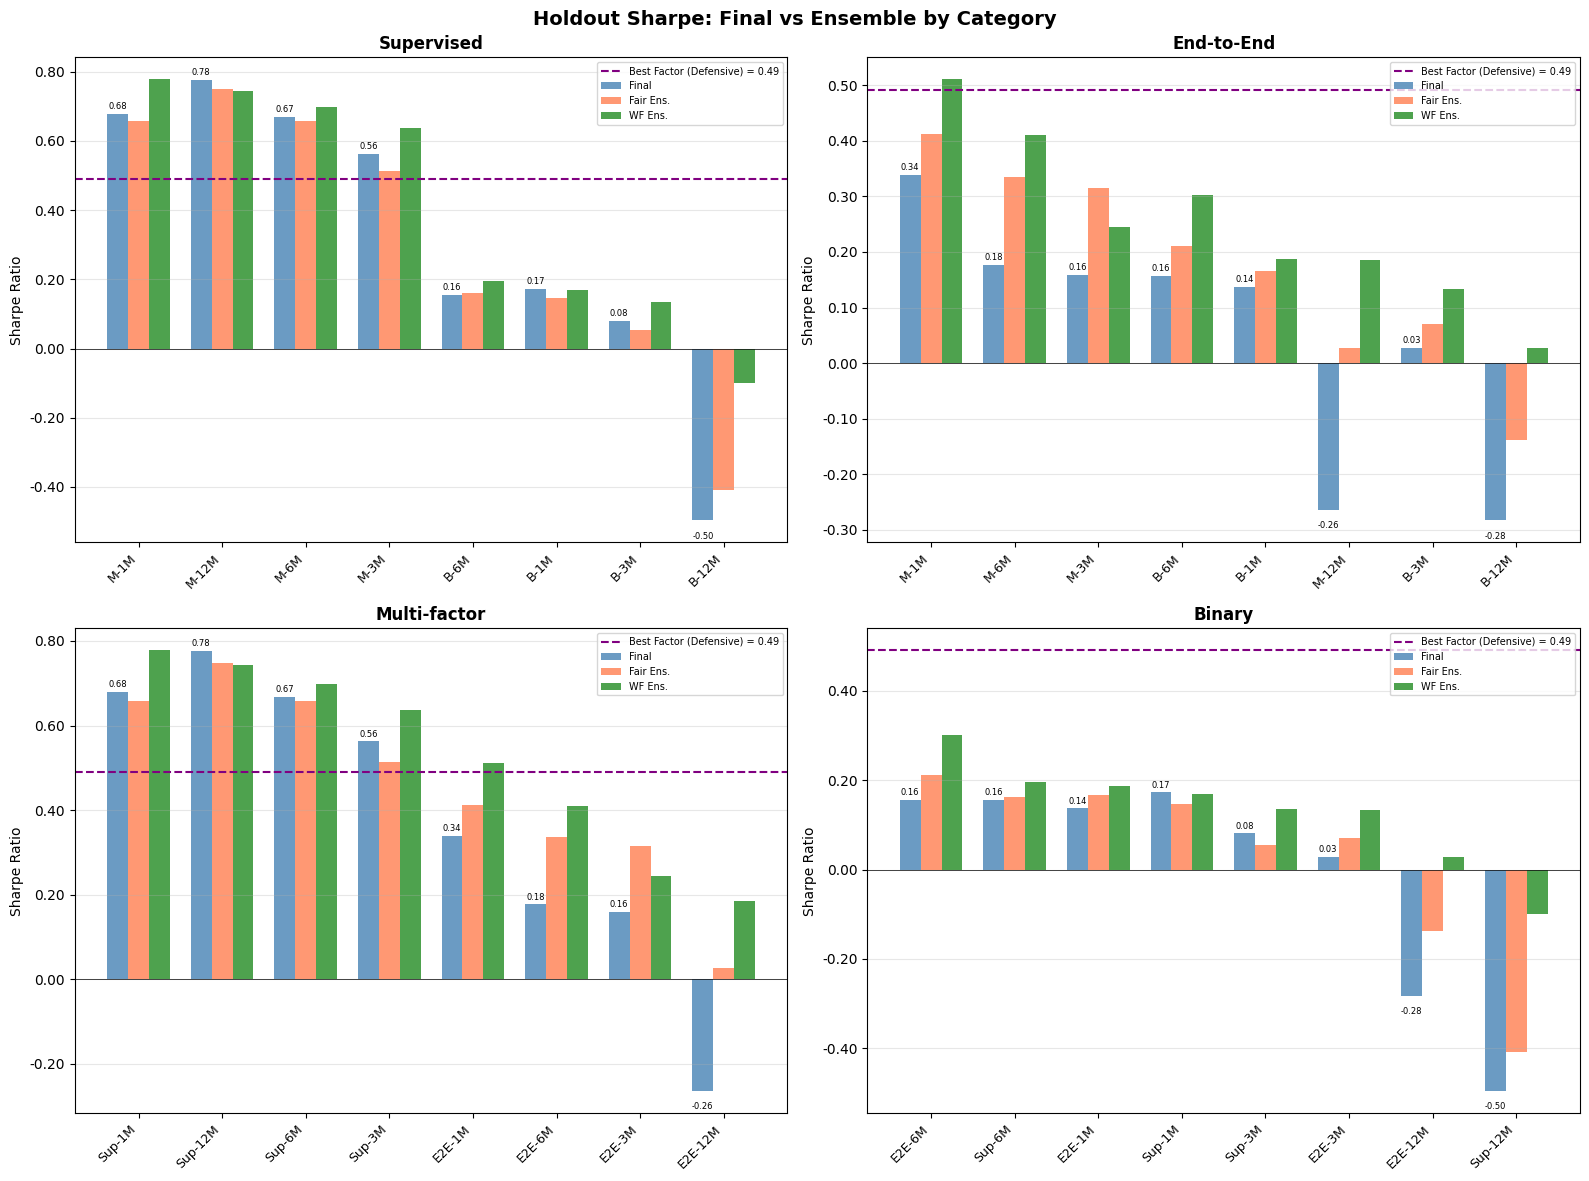

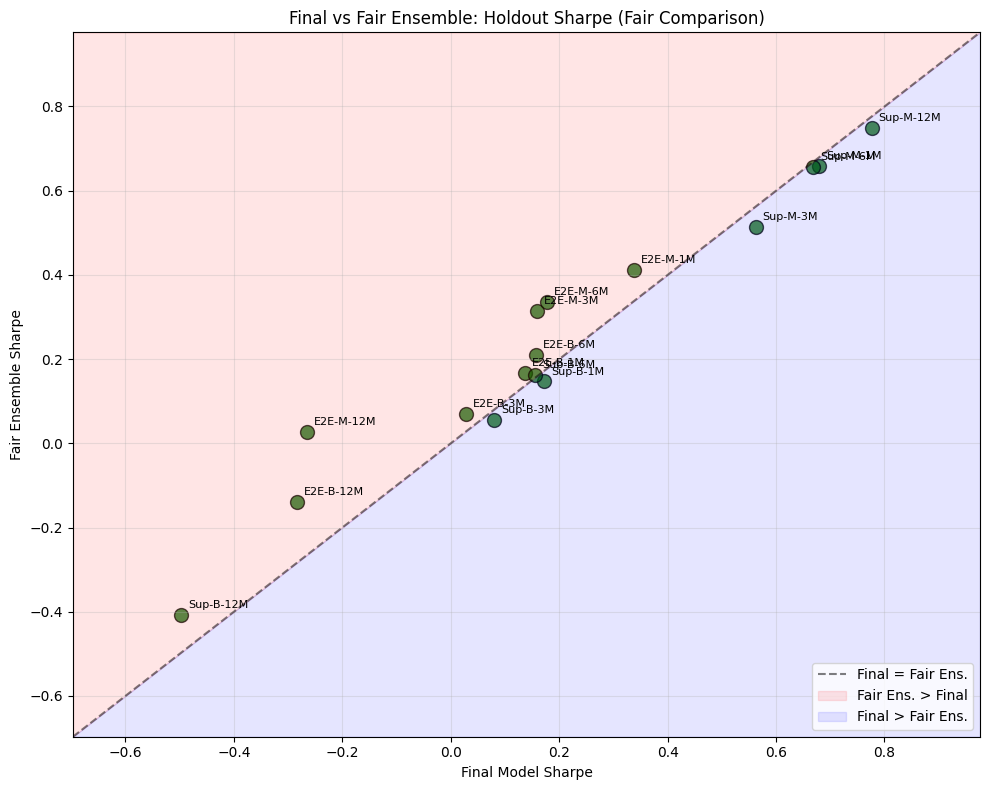

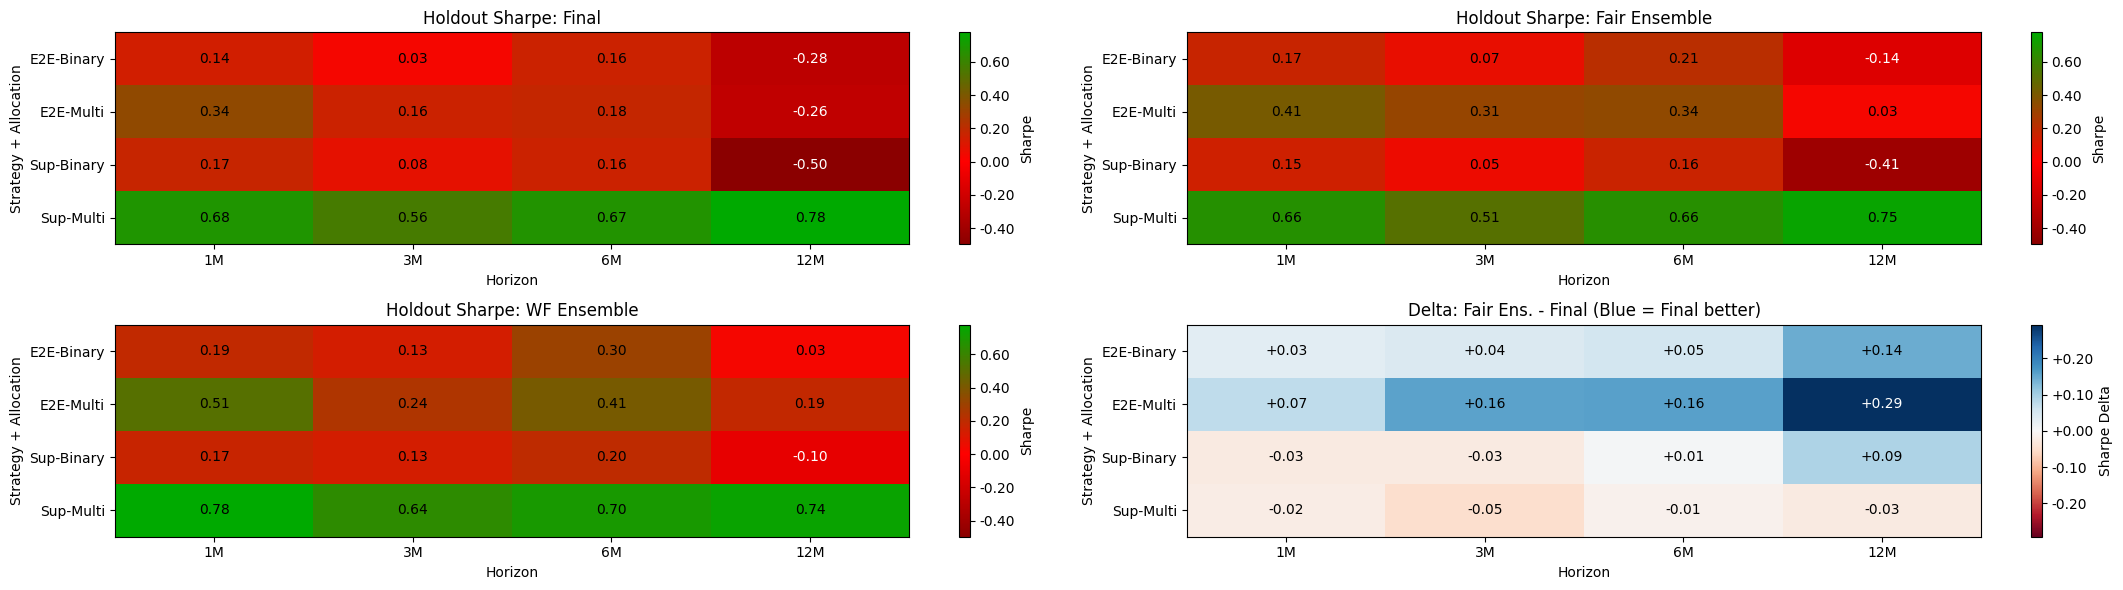

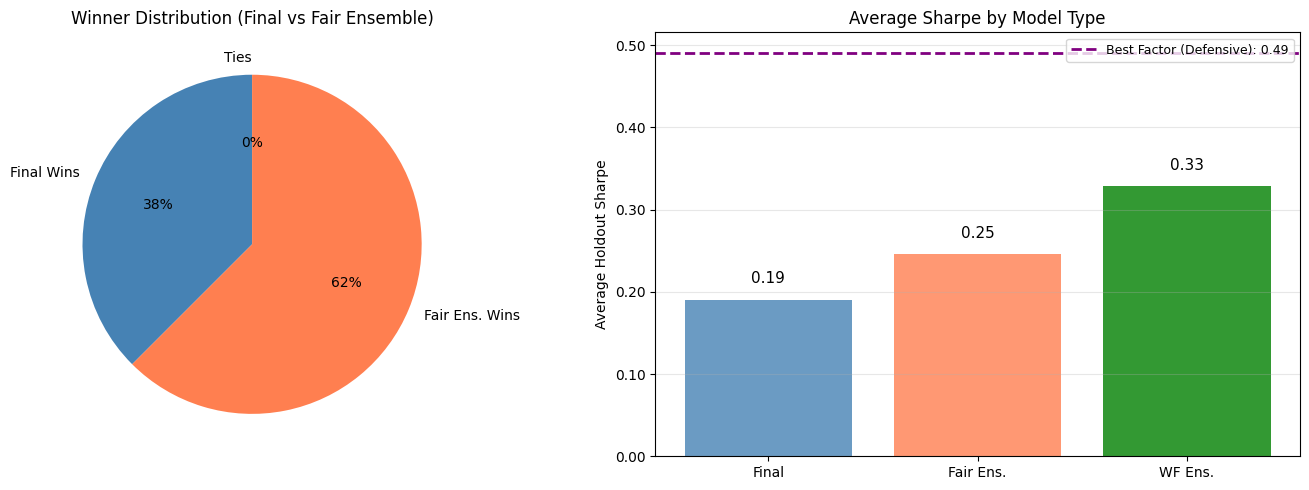

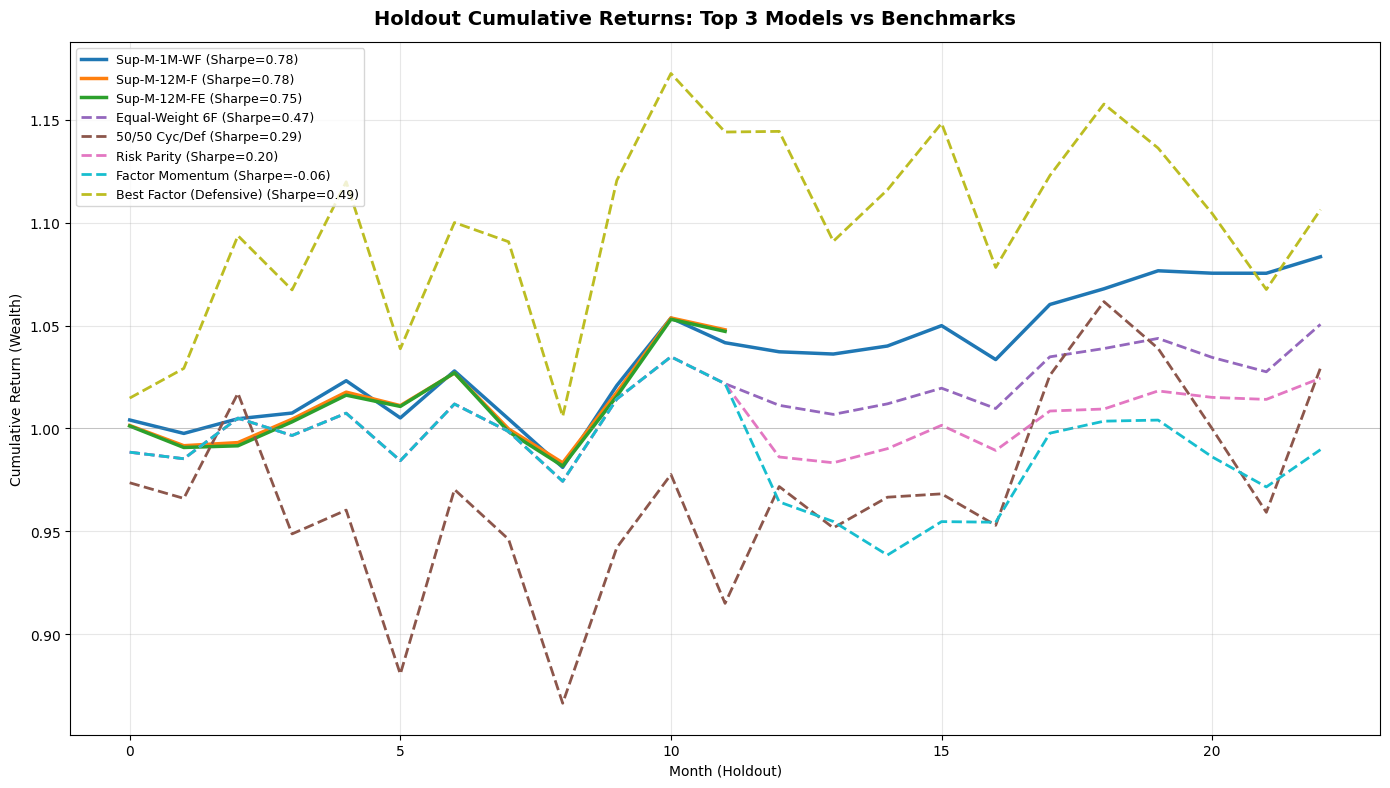


COMPLETE HOLDOUT RESULTS (with Composite Score)

Label              Strategy Alloc   H    Type           Sharpe       IC      MaxDD     Return    Score   Rank
------------------------------------------------------------------------------------------------------------------------
Sup-M-12M-WF       Sup      Multi   12M   WF Ens.         +0.74    +27.9%      -4.5%      +4.7%    79.9%      1
Sup-M-12M-FE       Sup      Multi   12M   Fair Ens.       +0.75    +16.6%      -4.4%      +4.7%    76.7%      2
E2E-M-1M-WF        E2E      Multi   1M   WF Ens.         +0.51    +19.1%      -3.4%      +5.2%    72.6%      3
Sup-M-1M-WF        Sup      Multi   1M   WF Ens.         +0.78     +0.7%      -4.6%      +8.3%    72.4%      4
E2E-M-12M-WF       E2E      Multi   12M   WF Ens.         +0.19    +49.6%      -4.4%      +1.2%    71.6%      5
Sup-M-1M-F         Sup      Multi   1M   Final           +0.68     -5.5%      -2.2%      +7.2%    71.4%      6
Sup-M-3M-FE        Sup      Multi   3M   Fair Ens.

In [11]:
# ============================================================
# HOLDOUT VISUALIZATIONS
# ============================================================

# Reload modules if needed (uncomment if you modified source code)
# reload_all()

# Compute benchmarks for the holdout period
holdout_start = pd.Timestamp("2022-01-01")
benchmarks = compute_all_benchmarks(factor_data, start_date=holdout_start)

# Plot all holdout visualizations with benchmarks
plot_all_holdout(
    all_holdout_results,
    horizons=[1, 3, 6, 12],
    compute_score_fn=compute_composite_score,
    benchmarks=benchmarks,
)

# ============================================================
# BEST MODELS vs BENCHMARKS (All Models)
# ============================================================

# Mapping for short names
type_abbrev = {"final": "F", "fair_ensemble": "FE", "wf_ensemble": "WF"}
strategy_abbrev = {"Sup": "Sup", "E2E": "E2E"}
alloc_abbrev = {"Multi": "M", "Binary": "B"}

# Collect ALL model results (no filter)
all_model_results = []
for key, result in all_holdout_results.items():
    strategy, allocation, horizon = key
    for model_type in ["final", "fair_ensemble", "wf_ensemble"]:
        if model_type in result and result[model_type] is not None:
            r = result[model_type]
            abbrev = type_abbrev[model_type]
            s_abbrev = strategy_abbrev[strategy]
            a_abbrev = alloc_abbrev[allocation]
            all_model_results.append({
                "name": f"{s_abbrev}-{a_abbrev}-{horizon}M-{abbrev}",
                "strategy": strategy,
                "allocation": allocation,
                "horizon": horizon,
                "type": model_type,
                "sharpe": r.sharpe,
                "ic": r.ic,
                "maxdd": r.maxdd,
                "return": r.total_return,
            })

# Find best by each criterion (across ALL models)
best_sharpe = max(all_model_results, key=lambda x: x["sharpe"])
best_ic = max(all_model_results, key=lambda x: x["ic"])
best_maxdd = max(all_model_results, key=lambda x: x["maxdd"])  # Less negative = better

# Build comparison table
print("\n" + "=" * 90)
print("BEST MODELS vs BENCHMARKS (All Models)")
print("=" * 90)
print(f"\n{'Name':<30} {'Sharpe':>10} {'IC':>10} {'MaxDD':>10} {'Return':>12}")
print("-" * 90)

# Best models section
print("BEST MODELS (by criterion):")
print(f"  Sharpe max:  {best_sharpe['name']:<20} {best_sharpe['sharpe']:>+10.4f} {best_sharpe['ic']:>+10.4f} {best_sharpe['maxdd']:>+10.4f} {best_sharpe['return']:>+11.2%}")
print(f"  IC max:      {best_ic['name']:<20} {best_ic['sharpe']:>+10.4f} {best_ic['ic']:>+10.4f} {best_ic['maxdd']:>+10.4f} {best_ic['return']:>+11.2%}")
print(f"  MaxDD min:   {best_maxdd['name']:<20} {best_maxdd['sharpe']:>+10.4f} {best_maxdd['ic']:>+10.4f} {best_maxdd['maxdd']:>+10.4f} {best_maxdd['return']:>+11.2%}")

print("-" * 90)
print("BENCHMARKS:")
for name, bench in benchmarks.items():
    # BenchmarkResult is a dataclass with: name, returns, sharpe, total_return, maxdd
    print(f"  {name:<28} {bench.sharpe:>+10.4f} {0.0:>+10.4f} {bench.maxdd:>+10.4f} {bench.total_return:>+11.2%}")

print("=" * 90)

# ============================================================
# EXPORT RESULTS FOR DASHBOARD
# ============================================================

# Add dashboard to path
if str(project_root / "dashboard") not in sys.path:
    sys.path.insert(0, str(project_root))

# Force reload the export module to pick up new function
import importlib
import dashboard.export_results
importlib.reload(dashboard.export_results)

from dashboard.export_results import (
    export_holdout_results_to_cache,
    export_walk_forward_results_to_cache,
    export_benchmarks_to_cache,
)

# Export holdout results (includes monthly returns)
export_holdout_results_to_cache(all_holdout_results)

# Export walk-forward results
export_walk_forward_results_to_cache(all_wf_results)

# Export benchmarks (includes monthly returns for cumulative chart)
export_benchmarks_to_cache(benchmarks)

print("\nResults exported! Run the dashboard with:")
print("  cd Strategies/factor_allocation_strategy_macro")
print("  streamlit run dashboard/app.py")